In [18]:
from pathlib import Path
import random
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from textwrap import indent, dedent

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-paper')
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from crawlercrawler import load_zip_json

# Fairseq Data schema
  * More complex than above, but has the same 3 features for each example, indicated by the first token on each line
    - `S-104` -- Source 104 (method example 104 given as source for translation
    - `H-104` -- Hypothesis 104 (generated docstring)
    - `T-104` -- Target 104 (target 'true' docstring)

In [2]:
ls /smartml-athena/processed-data/fundef-docstrings/split/multi-task-translation/fairseq/2020-04-17/generated

generate-test1.txt  generate-test7.txt  generate-test8.txt  generate-test.txt


In [19]:
name_map = {
        'test': 'Sig $\\to$ Doc',
        'test1': 'Sig $\\to$ Body',
        'test2': 'Sig $\\to$ Doc + Body',
        'test3': 'Doc $\\to$ Body',
        'test4': 'Doc $\\to$ Sig + Body',
        'test5': 'Body $\\to$ Doc',
        'test6': 'Body $\\to$ Sig + Doc',
        'test7': 'Sig + Doc $\\to$ Body',
        'test8': 'Sig + Body $\\to$ Doc',    
}

In [20]:
FAIRSEQ_MODELDIR = Path('/smartml-athena/processed-data/fundef-docstrings/split/multi-task-translation/fairseq')
TRANSLATION = FAIRSEQ_MODELDIR / '2020-04-17/generated/generate-test.txt'

SIG_TO_DOC = FAIRSEQ_MODELDIR / '2020-04-17/generated/generate-test.txt'
SIG_TO_BODY = FAIRSEQ_MODELDIR / '2020-04-17/generated/generate-test1.txt'
SIG_DOC_TO_BODY = FAIRSEQ_MODELDIR / '2020-04-17/generated/generate-test7.txt'
SIG_BODY_TO_DOC = FAIRSEQ_MODELDIR / '2020-04-17/generated/generate-test8.txt'
SIG_DOC_TO_BODY_CSN = FAIRSEQ_MODELDIR / '2020-04-17/generated-csn/generate-test7.txt'
SIG_BODY_TO_DOC_CSN = FAIRSEQ_MODELDIR / '2020-04-17/generated-csn/generate-test8.txt'
SIG_DOC_TO_BODY_BARONE = FAIRSEQ_MODELDIR / '2020-04-17/generated-barone/generate-test7.txt'
SIG_BODY_TO_DOC_BARONE = FAIRSEQ_MODELDIR / '2020-04-17/generated-barone/generate-test8.txt'

In [21]:
REPLACE = {'Ġ': ' ', 'Ċ': '\n', 'ĉ': '\t', 'NEWLINE': '\n', '<user_handle>': 'param'}

def fix_whitespace(string):
    """Return tokenized data to string literal"""
    for r, f in REPLACE.items():
        string = string.replace(r, f)
    return string

def decode(outlines):
    """Reads gathered fairseq-generate lines, returns src, hyp, tgt"""
    return [
            fix_whitespace(''.join(outlines[0][1:])),
            fix_whitespace(''.join(outlines[1][1:])),
            fix_whitespace(''.join(outlines[2][2:]))
    ]

def put_together():
    splitsrc = src.split('):\n')
    sig, body = splitsrc[0] + '):\n', '):\n'.join(splitsrc[1:])
    
    target = sig + '    """\n{}\n    """\n'.format(indent(tgt, ' '* 4)) + body
    hypothesis = sig + '    """\n{}\n    """\n'.format(indent(hyp, ' '* 4)) + body
    return [src, hypothesis, target]

def normalize_fairseq_schema(filepath):
    """Reads fairseq generated file and outputs results into a list of examples in the form of [src, hyp, tgt]"""
    gathered = defaultdict(list)
    with Path(filepath).open() as fin:
        for line in fin.readlines():
            if line[0] in ('S', 'T', 'H', 'P'):
                tokens = line.split()
                gathered[int(tokens[0].split('-')[1])].append(tokens)
    return [decode(gathered[k]) for k in gathered]

def gather_lines(filepath):
    """Reads fairseq generated file and outputs results into a list of examples in the form of [src, hyp, tgt]"""
    gathered = defaultdict(list)
    with Path(filepath).open() as fin:
        for line in fin.readlines():
            if line[0] in ('S', 'T', 'H', 'P'):
                tokens = line.split()
                gathered[int(tokens[0].split('-')[1])].append(tokens)
    return gathered

def get_perplexity(filepath):
    gathered = gather_lines(filepath)
    num_tokens_accum = 0
    num_examples = len(gathered)
    log_like_accum = 0
    ppl_accum = 0
    for example in gathered.values():
        for line in example:
            if 'T' in line[0]:
                num_tokens = len(line) - 1
            if 'H' in line[0]:
                log_like = float(line[1])
        num_tokens_accum += num_tokens
        ppl_accum += 2 ** - log_like
        log_like_accum += log_like# * num_tokens
    return log_like_accum, ppl_accum, num_examples, num_tokens_accum

In [23]:
#dat_sig_to_doc = normalize_fairseq_schema(SIG_TO_DOC)
#dat_sig_to_body = normalize_fairseq_schema(SIG_TO_BODY)
dat_sig_doc_to_body = normalize_fairseq_schema(SIG_DOC_TO_BODY)
dat_sig_body_to_doc = normalize_fairseq_schema(SIG_BODY_TO_DOC)

In [24]:
dat_sig_doc_to_body_csn = normalize_fairseq_schema(SIG_DOC_TO_BODY_CSN)
dat_sig_body_to_doc_csn = normalize_fairseq_schema(SIG_BODY_TO_DOC_CSN)

In [25]:
dat_sig_doc_to_body_barone = normalize_fairseq_schema(SIG_DOC_TO_BODY_BARONE)
dat_sig_body_to_doc_barone = normalize_fairseq_schema(SIG_BODY_TO_DOC_BARONE)

## Test set ablation: remove 'test' methods and methods which have fewer than 3 lines

In [30]:
dat_sig_doc_to_body_ablated = []
for dat in dat_sig_doc_to_body:
    if 'test' in dat[0].casefold():
        continue
    if len(dat[1].splitlines()) < 3:
        continue
    dat_sig_doc_to_body_ablated.append(dat)

In [33]:
len(dat_sig_doc_to_body_ablated)/len(dat_sig_doc_to_body)

0.5922684856014022

In [32]:
len(dat_sig_doc_to_body)

383961

## See how close hyp and tgt are to find clones

In [81]:
import editdistance

In [113]:
body_dists = []
for d in dat_sig_doc_to_body_csn:
    src, hyp, tgt = d
    body_dists.append(editdistance.eval(clean(hyp), clean(tgt)))

In [86]:
import numpy as np
import matplotlib.pyplot as plt

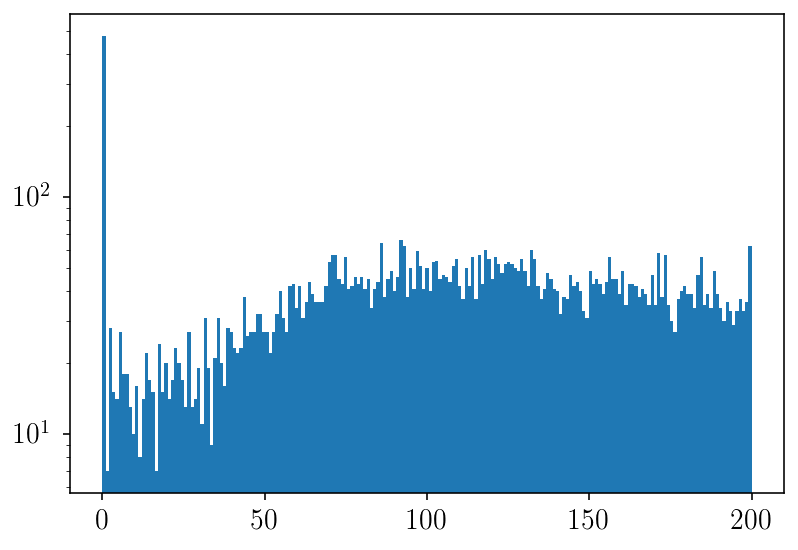

In [140]:
bins = np.linspace(0, 200, 200)
plt.hist(body_dists, bins=bins);plt.yscale('log')

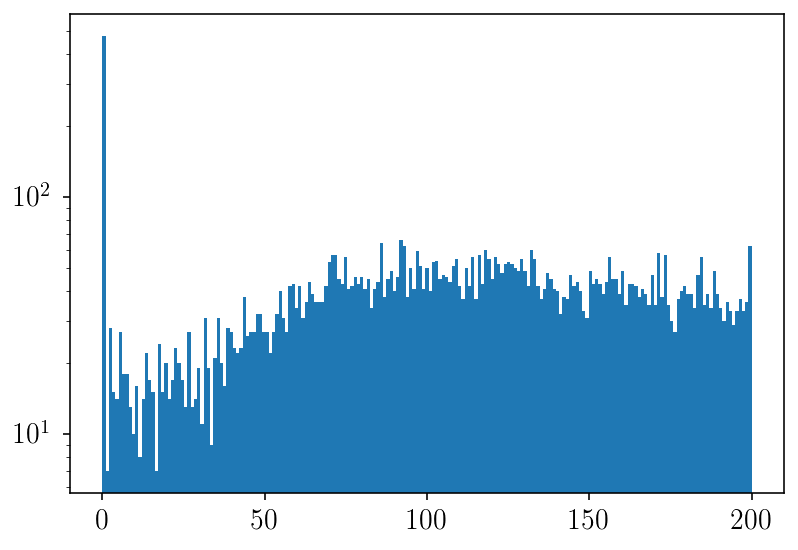

In [118]:
bins = np.linspace(0, 200, 200)
plt.hist(body_dists, bins=bins);plt.yscale('log')

In [121]:
n_zero = sum([b for b in body_dists if b < 2])

In [122]:
n_zero

12

In [37]:
from nltk.translate import bleu, bleu_score

def clean(s):
    return dedent(s.replace('"""', '').strip())

def get_bleu(dat, head=None, thin=None):
    refs, hyps = [], []
    if head is not None:
        dat = dat[:head]
    if thin is not None:
        dat = dat[::thin]
    for d in dat:
        r, h = clean(d[2]).split(), clean(d[1]).split()
        if len(r) > 4 and len(h) > 4:
            refs.append(r)
            hyps.append(h)

    return bleu_score.corpus_bleu(refs, hyps)

In [50]:
get_bleu(dat_sig_body_to_doc)

0.2524708854811798

In [ ]:
get_bleu(dat_sig_doc_to_body)

In [44]:
get_bleu(dat_sig_doc_to_body_ablated)

6.482332062304086e-156

In [32]:
get_bleu(dat_sig_to_body)

0.07571818936201223

In [33]:
get_bleu(dat_sig_to_doc)

0.22420588170222316

In [123]:
get_bleu(dat_sig_doc_to_body_csn)

0.08592604226728165

In [124]:
get_bleu(dat_sig_body_to_doc_csn)

0.16336617008637147

In [52]:
get_bleu(dat_sig_doc_to_body_barone)

0.20232112527326734

In [37]:
get_bleu(dat_sig_body_to_doc_barone)

0.17382519588719936

In [139]:
for t, f in zip(['src', 'hyp', 'tgt'], dat_sig_body_to_doc_csn[1132]):
    print(f'{t}:')
    print(f)
    print('\n')

src:
# target docstring style oneline
def subs_consts(self, expr):
    if isinstance(expr, numbers.Number):
        return expr
    else:
        return expr.subs(self.constants)


hyp:
    """Substitute constants in expression unless it is already a number."""


tgt:
    """Substitute constants in an expression."""




In [34]:
from multiprocessing import Pool
from collections import defaultdict

In [ ]:
#NOTE: make get_dat_folds grab enough 

In [41]:
def get_dat_folds(dat, size, number, maxlen=None, seed=98115):
    if maxlen is not None:
        dat = dat[:maxlen]  # for consistent shuffle

    dat_filtered = [d for d in dat if len(d[1]) > 0 and len(d[2])> 0]
    order = np.arange(len(dat_filtered))
    rng = np.random.RandomState(1)
    rng.shuffle(order)
    
    folds = [order[i * size: (i + 1) * size] for i in range(number)]
    foldlist = []
    for fold in folds:
        hyp, ref = [], []
        for i in fold:
            if len(dat_filtered[i][1]) > 0 and len(dat_filtered[i][2])> 0:
                hyp.append(dat_filtered[i][1])
                ref.append(dat_filtered[i][2])
        foldlist.append([hyp, ref])
    return foldlist

datasets = {
    'docstring-gen': dat_sig_body_to_doc,
    'method-gen': dat_sig_doc_to_body,
    'method-gen-ablated': dat_sig_doc_to_body_ablated,
    'docstring-gen-csn': dat_sig_body_to_doc_csn,
    'method-gen-csn': dat_sig_doc_to_body_csn,
    'docstring-gen-barone': dat_sig_body_to_doc_barone,
    'method-gen-barone': dat_sig_doc_to_body_barone,
}

maxlen = min([len(d) for d in datasets.values()])


# fold_list = []
# for label, dat in datasets.items():
#     for fold in get_dat_folds(dat, 1024, 12, maxlen=maxlen):
#         fold_list.append((label, fold))

In [8]:
dat_sig_doc_to_body_csn[0]

['# target body \ndef shell():\n    """Open a shell"""',
 '    from gui.tools.debug import Shell\n    shell = Shell()\n    shell.show()\n    return shell',
 '    from IPython.core.interactiveshell import InteractiveShell\n    return InteractiveShell()']

In [41]:
from rouge import Rouge

def get_rouge(fold):
    label, (hyp, ref) = fold
    return fold[0], Rouge().get_scores('\n'.join(hyp), '\n'.join(ref))[0]

def get_rouge_improved(fold):
    dat, label = fold
    hyps, refs = [], []
    for d in dat:
        if d[1].strip() and d[2].strip():
            hyps.append(d[1])
            refs.append(d[2])
    r = Rouge()
    renorm = len(hyps)/len(dat)
    scores = r.get_scores(hyps, refs, avg=True)
    for metric in scores:
        for stat in scores[metric]:
            scores[metric][stat] *= renorm
    return scores, label

In [43]:
get_rouge_improved((dat_sig_doc_to_body_ablated, 'ablated-method-test'))

({'rouge-1': {'f': 0.29653015782456793,
   'p': 0.2607048897673985,
   'r': 0.42896483169585253},
  'rouge-2': {'f': 0.17277762612513936,
   'p': 0.15910468707051648,
   'r': 0.22319177467594453},
  'rouge-l': {'f': 0.2611243539883778,
   'p': 0.25817991370326066,
   'r': 0.4244873460218464}},
 'ablated-method-test')

In [17]:
def flatten_dict(results):
    flatdict = {}
    for metric in ('rouge-1', 'rouge-2', 'rouge-l'):
        flatdict[metric] = {}
        for stat in ('f', 'p', 'r'):
            flatdict[metric][stat] = []
            for r in results:
                flatdict[metric][stat].append(r[metric][stat])
    return flatdict

In [44]:
from multiprocessing import Pool
pool = Pool()

results_dict = defaultdict(list)
fold_list = [(v, k) for k, v in datasets.items()]
for r in pool.map(get_rouge_improved, fold_list):
    results_dict[r[1]].append(r[0])

for model in results_dict:
    results_dict[model] = flatten_dict(results_dict[model])

In [45]:
from pprint import pprint
pprint(results_dict)

defaultdict(<class 'list'>,
            {'docstring-gen': {'rouge-1': {'f': [0.43314323741364524],
                                           'p': [0.42114400604290836],
                                           'r': [0.5044596909003224]},
                               'rouge-2': {'f': [0.244706135773213],
                                           'p': [0.237694396275879],
                                           'r': [0.270454535837472]},
                               'rouge-l': {'f': [0.39820431776928733],
                                           'p': [0.4125527674597647],
                                           'r': [0.49312668942264337]}},
             'docstring-gen-barone': {'rouge-1': {'f': [0.4306995383527099],
                                                  'p': [0.3964209826978897],
                                                  'r': [0.5360861288972999]},
                                      'rouge-2': {'f': [0.277709413450045],
                             

In [157]:
results_dict.keys()

dict_keys(['docstring-gen', 'method-gen'])

In [158]:
def mean_std_dict(results):
    meandict = {}
    stddict = {}
    for metric in results:
        meandict[metric] = {}
        stddict[metric] = {}
        for stat in results[metric]:
            meandict[metric][stat] = np.mean(results[metric][stat])
            stddict[metric][stat] = np.std(results[metric][stat])
    return meandict, stddict

In [230]:
def round_one_sig_fig(num):
    p = - np.floor(np.log10(num) if num < 1 else np.log10(num))
    return np.round(10 ** p * num) / 10 ** p, p

def round_to_error(num, err):
    err_round, p = round_one_sig_fig(err)
    return np.round(num * 10 ** p) / 10 ** p, err_round * 10 ** p, int(p)

def printStr(FloatNumber, Precision):
    return "%0.*f" % (Precision, FloatNumber)

In [234]:
def pretty_print(results):
    for model in results:
        try:
            means, stds = mean_std_dict(results[model])
        except TypeError:
            means, stds = results[model]
        print(f'{model}:')
        for metric in means:
            print(f'\t{metric}:')
            for stat in means[metric]:
                m, s = means[metric][stat], stds[metric][stat]
                num, err, p = round_to_error(m, s)
                num_str = printStr(num, p)
                err_str = printStr(err, 0)
                print(f'\t\t{stat} = {num_str}({err_str})')
                #print(f'\t\t{stat} = {m:.4f} +/- {s:.4f}')

In [302]:
pretty_print(results_dict)

docstring-gen:
	rouge-1:
		f = 0.55(2)
		p = 0.46(2)
		r = 0.69(1)
	rouge-2:
		f = 0.37(2)
		p = 0.30(2)
		r = 0.48(2)
	rouge-l:
		f = 0.50(2)
		p = 0.44(2)
		r = 0.67(1)
method-gen:
	rouge-1:
		f = 0.26(1)
		p = 0.192(10)
		r = 0.40(1)
	rouge-2:
		f = 0.19(1)
		p = 0.141(9)
		r = 0.28(1)
	rouge-l:
		f = 0.21(1)
		p = 0.190(9)
		r = 0.39(1)


In [236]:
#jonathan's gpt2 results
jonathan_gpt2_results = {
'method-gen-rand': 
    ({'rouge-1': {'f': 0.38433325024061543, 'p': 0.4584062821227271, 'r': 0.3315110754542952}, 'rouge-2': {'f': 0.13285892817794104, 'p': 0.15844627229077263, 'r': 0.11460919803605539}, 'rouge-l': {'f': 0.16577386368695593, 'p': 0.27511412676654096,
 'r': 0.11872569039963489}}, {'rouge-1': {'f': 0.009161686542498161, 'p': 0.013326972542123814, 'r': 0.01611866956891867}, 'rouge-2': {'f': 0.005894118064149998, 'p': 0.0069906581064086495, 'r': 0.007242612385506144}, 'rouge-l': {'f': 0.006198035366921738,
 'p': 0.007966553646826226, 'r': 0.005884616271523124}}),

 'method-gen-eng': ({'rouge-1': {'f': 0.39119127578568474, 'p': 0.4540369622874434, 'r': 0.34411688094585346}, 'rouge-2': {'f': 0.13298913802397813, 'p': 0.15434283441470267, 'r': 0.11699201449078596}, 'rouge-l': {'f': 0.16654715696370487, 'p': 0.2683579717149785,
 'r': 0.12083338789561891}}, {'rouge-1': {'f': 0.008336954206552364, 'p': 0.007988165604640128, 'r': 0.015304736457389143}, 'rouge-2': {'f': 0.0055975448804762365, 'p': 0.005926486932865289, 'r': 0.006825432484127693}, 'rouge-l': {'f': 0.006078794839321041,
 'p': 0.007857515930007091, 'r': 0.00582440048339301}}),

'doc-gen-rand': ({'rouge-1': {'f': 0.5644844015323888, 'p': 0.5668269105085031, 'r': 0.5626508211818182}, 'rouge-2': {'f': 0.28388318892321807, 'p': 0.285131808904222, 'r': 0.28289791662517133}, 'rouge-l': {'f': 0.37781237611282564, 'p': 0.4204008709533699,
 'r': 0.34314015381145097}}, {'rouge-1': {'f': 0.009233420394944087, 'p': 0.0072658423791337485, 'r': 0.019400806006785207}, 'rouge-2': {'f': 0.005960377348473731, 'p': 0.008302215205747553, 'r': 0.00868949411273426}, 'rouge-l': {'f': 0.00810814552056161,
 'p': 0.01110186953421851, 'r': 0.007639302884674334}}),
 
'doc-gen-eng': ({'rouge-1': {'f': 0.5689913390322396, 'p': 0.5688607253768754, 'r': 0.5695238586477182}, 'rouge-2': {'f': 0.2836226966720744, 'p': 0.28357030357314766, 'r': 0.2838779244551932}, 'rouge-l': {'f': 0.3780184284077497, 'p': 0.42262503722605277,
 'r': 0.3420248773367247}}, {'rouge-1': {'f': 0.008575277993075621, 'p': 0.007820658885445277, 'r': 0.017463756175751133}, 'rouge-2': {'f': 0.0054173392842781125, 'p': 0.005792107719432294, 'r': 0.009073435484787357}, 'rouge-l': {'f': 0.008920603839517535,
 'p': 0.010946063614451837, 'r': 0.009308427296058361}})
}


pretty_print(jonathan_gpt2_results)



method-gen-rand:
	rouge-1:
		f = 0.384(9)
		p = 0.46(1)
		r = 0.33(2)
	rouge-2:
		f = 0.133(6)
		p = 0.158(7)
		r = 0.115(7)
	rouge-l:
		f = 0.166(6)
		p = 0.275(8)
		r = 0.119(6)
method-gen-eng:
	rouge-1:
		f = 0.391(8)
		p = 0.454(8)
		r = 0.34(2)
	rouge-2:
		f = 0.133(6)
		p = 0.154(6)
		r = 0.117(7)
	rouge-l:
		f = 0.167(6)
		p = 0.268(8)
		r = 0.121(6)
doc-gen-rand:
	rouge-1:
		f = 0.564(9)
		p = 0.567(7)
		r = 0.56(2)
	rouge-2:
		f = 0.284(6)
		p = 0.285(8)
		r = 0.283(9)
	rouge-l:
		f = 0.378(8)
		p = 0.42(1)
		r = 0.343(8)
doc-gen-eng:
	rouge-1:
		f = 0.569(9)
		p = 0.569(8)
		r = 0.57(2)
	rouge-2:
		f = 0.284(5)
		p = 0.284(6)
		r = 0.284(9)
	rouge-l:
		f = 0.378(9)
		p = 0.42(1)
		r = 0.342(9)


In [170]:
import numpy as np

In [172]:
-np.log10(0.0054)

2.2676062401770314

In [193]:
def round_one_sig_fig(num):
    p = - np.floor(np.log10(num) if num < 1 else np.log10(num))
    return np.round(10 ** p * num) / 10 ** p

In [200]:
round_one_sig_fig(16)

20.0

In [206]:
round_to_error(0.5645, 0.0092)

(0.564, 0.009)

In [190]:
np.floor(np.log10(0.0089))

-3.0

In [202]:
np.round(0.378 / 10 ** -3.) * 10 ** -3.

0.378

In [208]:
np.round()

## Check syntactic correctness

In [15]:
import ast
def check_syntax(method):
    try:
        ast.parse(method)
        return True
    except (SyntaxError, MemoryError) as _:
        return False
    
def make_hyp(src_hyp_tgt):
    src, tgt, hyp = src_hyp_tgt
    return '\n'.join([src, hyp])

In [56]:
dat_sig_doc_to_body_csn[::20][27]

['# target body \ndef use(self, profile):\n    """Define a new default profile."""',
 "    if (not isinstance(profile, (KnownProfiles, ProfileDefinition))):\n        raise ValueError('Can only set as default a ProfileDefinition or a KnownProfiles')\n    type(self).profile = profile",
 '    if (profile not in self.profiles):\n        self.profiles.append(profile)']

In [57]:
for i, dd in enumerate(dat_sig_doc_to_body_csn):
    if 'def run_cli(self, hql, schema=None, verbose=True, hive_conf=None):' in dd[0]:
        break

In [72]:
syntactic = [check_syntax(make_hyp(d)) for d in dat_sig_doc_to_body_csn]
print(len(syntactic))
print(len(syntactic)-sum(syntactic))
print(sum(syntactic) / len(syntactic))

19688
1559
0.9208147094676961


In [74]:
syntactic = [check_syntax(make_hyp(d)) for d in dat_sig_doc_to_body_barone]
print(len(syntactic))
print(len(syntactic)-sum(syntactic))
print(sum(syntactic) / len(syntactic))

1698
150
0.911660777385159


In [17]:
syntactic = [check_syntax(make_hyp(d)) for d in dat_sig_doc_to_body]
print(len(syntactic))
print(len(syntactic)-sum(syntactic))
print(sum(syntactic) / len(syntactic))

383961
24691
0.9356939897541677


In [364]:
from fairseq.models.transformer import TransformerModel
from tokenizers import ByteLevelBPETokenizer

In [505]:
ls /smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring

data-bin/
dawn-fairseq/
dawn-fairseq-javadoc-problems/
fairseq/
python-func-def-docstrings-2020-02-21-2026_bytelevelbpe_30000-merges.txt
python-func-def-docstrings-2020-02-21-2026_bytelevelbpe_30000-vocab.json
python-func-def-docstrings-2020-02-21-2026.test.docstring.json.gz
python-func-def-docstrings-2020-02-21-2026.test.methods.json.gz
python-func-def-docstrings-2020-02-21-2026.train.docstring.json.gz
python-func-def-docstrings-2020-02-21-2026.train.methods.json.gz
python-func-def-docstrings-2020-02-21-2026.val.docstring.json.gz
python-func-def-docstrings-2020-02-21-2026.val.methods.json.gz
python-func-def-docstrings-2020-03-04-2336.test.docstring.json.gz
python-func-def-docstrings-2020-03-04-2336.test.methods.json.gz
python-func-def-docstrings-2020-03-04-2336.train.docstring.json.gz
python-func-def-docstrings-2020-03-04-2336.train.methods.json.gz
python-func-def-docstrings-2020-03-04-2336.val.docstring.json.gz
python-func-def-docstrings-2020-03-04-2336.val.methods.json.gz


In [507]:
ROOT = Path('/smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring')
MODEL_ROOT = ROOT / 'fairseq/2020-02-25/'
MODEL_CHECKPOINT = MODEL_ROOT / 'checkpoint_best.pt'
DATADIR = '/smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring/fairseq/binary_javadoc_problems'

# TOKENIZER_ROOT = Path('/smartml-athena/processed-data/fundef-docstrings/dawn-py-pretrained/forColin')
# VOCAB_FILE = str(TOKENIZER_ROOT / 'hacky_byte_level-vocab.json')
# MERGES_FILE = str(TOKENIZER_ROOT / 'hacky_byte_level-merges.txt')

TOKENIZER_PREFIX = 'python-func-def-docstrings-2020-02-21-2026_bytelevelbpe_30000-'
VOCAB_FILE = str(ROOT / (TOKENIZER_PREFIX + 'vocab.json'))
MERGES_FILE = str(ROOT / (TOKENIZER_PREFIX + 'merges.txt'))

tokenizer = ByteLevelBPETokenizer(VOCAB_FILE, MERGES_FILE)


In [570]:
model = TransformerModel.from_pretrained(
    MODEL_ROOT,
    checkpoint_file='checkpoint_best.pt',
    data_name_or_path=DATADIR,
)

model.to('cuda')

2020-04-07 20:29:09,039 - fairseq.file_utils - INFO: loading archive file /smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring/fairseq/2020-02-25 from cache at /smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring/fairseq/2020-02-25
2020-04-07 20:29:09,040 - fairseq.file_utils - INFO: loading archive file /smartml-athena/processed-data/fundef-docstrings/split/translate-method-docstring/fairseq/binary_javadoc_problems
2020-04-07 20:29:11,823 - fairseq.tasks.translation - INFO: [methods] dictionary: 29936 types
2020-04-07 20:29:11,824 - fairseq.tasks.translation - INFO: [docstring] dictionary: 29936 types
2020-04-07 20:29:17,277 - fairseq.models.fairseq_model - INFO: Namespace(activation_dropout=0.2, activation_fn='relu', adam_betas='(0.9,0.98)', adam_eps=1e-06, adaptive_input=False, adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0, all_gather_list_size=16384, arch='transformer', attention_dropout=0.1, best_checkpoint_metri

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerModel(
      (encoder): TransformerEncoder(
        (embed_tokens): Embedding(29936, 1472, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (k_proj): Linear(in_features=1472, out_features=1472, bias=True)
              (v_proj): Linear(in_features=1472, out_features=1472, bias=True)
              (q_proj): Linear(in_features=1472, out_features=1472, bias=True)
              (out_proj): Linear(in_features=1472, out_features=1472, bias=True)
            )
            (self_attn_layer_norm): _FusedLayerNorm(torch.Size([1472]), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1472, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1472, bias=True)
            (final_layer_norm): _FusedLayerNorm(torch.Size([1472]

In [523]:
from fairseq.search import Sampling

In [569]:
TransformerModel.from_pretrained?

In [575]:
def translate(plain_text, tokenizer=tokenizer, model=model):
    encoding = ' '.join(tokenizer.encode(plain_text).tokens)
    return fix_whitespace(''.join(model.translate(
        encoding, beam=5, temperature=1.).split()))

In [576]:
print(dat_translation[247102][0])
print('\n')
print(translate(dat_translation[247102][0]))
print(dat_translation[247102][2])

def add_insect(self, insect):
    if insect.is_ant:
        if (self.ant is None):
            self.ant = insect
        elif self.ant.can_contain(insect):
            self.ant.ant = insect
        elif insect.can_contain(self.ant):
            insect.ant = self.ant
            self.ant = insect
        else:
            assert (self.ant is None), 'Two ants in {0}'.format(self)
    else:
        self.bees.append(insect)
    insect.place = self


Add an INSECT to this Place.
Add an INSECT to this Place.


In [564]:
print(translate(dat_translation[121582][0]))

isShapeInsideOfBox(shapeCoordinates, boxCoordinates) -> True if
shapeCoordinates is inside the box, False otherwise.


In [443]:
key = random.randint(0, len(dat_translation))
print(key)
print(dat_translation[key][0])
print(dat_translation[key][1])

121582
def isShapeInsideOfBox(self, shapeCoordinates, boxCoordinates):
    for point in shapeCoordinates:
        if (not self.isPointInsideOfBox(point, boxCoordinates)):
            return False
    return True
Go through every point in the shape to test if they are all inside the box.


In [404]:
print(dat_pretrained_translation[key][0])
print(dat_pretrained_translation[key][1])

def handle_paragraph(self, tag):
    name = tag.name
    print(tag)
    if tag.find('label'):
        print(tag)
        label = tag.split('label ')[(- 1)]
        return '\n\\begin{{{name}}} \\label{{{label}}}\n    {content}\n\\end{{{name}}}\n'.format(name='subsection', content=self.format(tag), label=label)
    else:
        return '\n\\begin{{{name}}}\n    {content}\n\\end{{{name}}}\n'.format(name=self.tag_to_latex[name], content=self.format(tag))
Parameters
----------
tag: QqTag

Returns "egin{subsection}
            tag content
         \end{subsection}
-------


In [400]:
random.randint(0, len(dat_translation))

111844